# Image Captioning
This Notebook is basically made to design a model which using visual data can caption images which is give a 2-3 lines summary of what is actually available in the picture itself...
We will be combining Two SOTA Models here which are:>
1. Efficient Net [link](https://arxiv.org/abs/1905.11946)
2. RoBERTa [link](https://arxiv.org/abs/1907.11692)

# Imports



In [ ]:
from zipfile import
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Loading the Dataset
**NOTE** : Before you run this please check the files section

In [ ]:
tf.__version__

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

In [ ]:
from zipfile import ZipFile, BadZipFile
import os

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)

        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)

    except BadZipFile as e:
        print("Error:", e)
extract_train_path = "./coco_train2017"
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"

extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

# DataFrame Creation

In [ ]:
BASE_PATH = '/content'

In [ ]:
with open(f'{BASE_PATH}/coco_ann2017/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

data = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
data['image'] = data['image'].apply(
    lambda x: f'{BASE_PATH}/coco_train2017/train2017/{x}'
)
data = data.sample(70000)
data = data.reset_index(drop=True)
data.head()

Testing With One Image

In [ ]:
def image_with_captions(image_path, captions):
  image = plt.imread(image_path)
  plt.imshow(image)
  print(image.shape)
  plt.title(captions)
  plt.axis('off')

In [ ]:
image_with_captions(data.image[0],data.caption[0])

In [ ]:
import matplotlib.pyplot as plt

# Calculate caption lengths
caption_lengths = data['caption'].apply(lambda x: len(x.split()))

# Plot histogram
plt.hist(caption_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Caption Length Distribution')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Function to display sample images with captions
def display_samples(data, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        image = plt.imread(data['image'][i])
        axes[i].imshow(image)
        axes[i].set_title(data['caption'][i])
        axes[i].axis('off')
    plt.show()

# Display sample images with captions
display_samples(data)


# Text Encoding

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [ ]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 15000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 5

Tokenization
> Text ------------> Input Tensors

In [ ]:
data['tokenizedCaptions'] = data.caption.apply(lambda x : tokenizer(
    text=x,
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    truncation=True,
    padding='max_length',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)['input_ids'])

In [ ]:
data

In [ ]:
type(data.tokenizedCaptions[0])

In [ ]:
vr = data.tokenizedCaptions[0]
len(vr)

In [ ]:
import random, collections

In [ ]:
data.caption.dtype

In [ ]:
x = data['image'].to_list()
y = data['tokenizedCaptions'].to_list()

In [ ]:
x

In [ ]:
def load_data(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    return img

In [ ]:
print(y[0])

In [ ]:
load_data(x[0])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(x_train)
X_train = X_train.map(load_data,num_parallel_calls=tf.data.AUTOTUNE)
Y_train = tf.data.Dataset.from_tensor_slices(y_train)
X_test = tf.data.Dataset.from_tensor_slices(x_test)
X_test = X_test.map(load_data,num_parallel_calls=tf.data.AUTOTUNE)
Y_test = tf.data.Dataset.from_tensor_slices(y_test)

In [ ]:
train_dataset = tf.data.Dataset.zip((X_train, Y_train))
test_dataset = tf.data.Dataset.zip((X_test, Y_test))
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset

In [ ]:
test_dataset

# Model 1
### Architecture
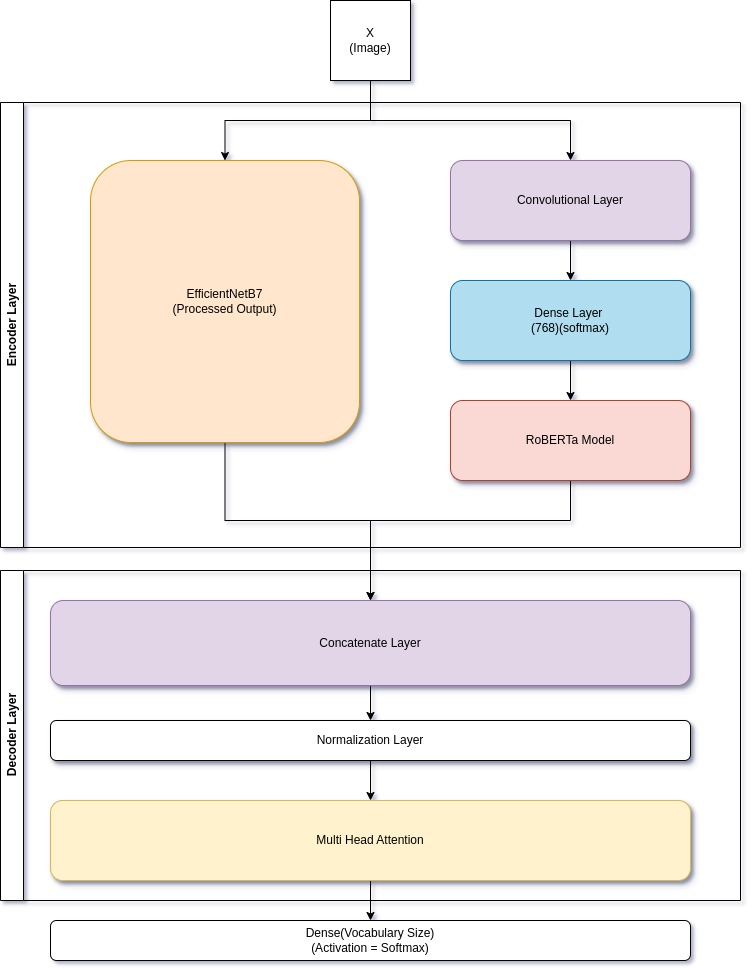  
### Problem
As the model has over a Billion parameters we need to lower down the complexity so that we can eventually it on the colab servers

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

EffNetEncoder
> 1. Import Efficient_net architecture with weights
2. remove classification layer from the output layer as we are only interested in the embeddings provided after we preprocess the data using the model
3. save the model

In [ ]:
class EffNetEncoder(tf.keras.layers.Layer):
  def __init__(self,neuron = 768, **kwargs):
    super(EffNetEncoder,self).__init__(**kwargs)
    self.model = tf.keras.applications.EfficientNetB0(include_top = False,weights = 'imagenet')
    self.dense = tf.keras.layers.Dense(neuron)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, x):
    x = preprocess_input(x)
    x = self.model(x)
    x = self.flatten(x)
    outputs = self.dense(x)
    return outputs


In [ ]:
from transformers import TFRobertaModel

class RobertaEncoder(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RobertaEncoder,self).__init__(**kwargs)
        self.roberta_model = TFRobertaModel.from_pretrained('roberta-base')
        input_shape = (224,224,3)
        self.conv = tf.keras.Sequential([
                      # Convolutional layers
                      tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape),
                      tf.keras.layers.MaxPooling2D(pool_size=2),
                      tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'),
                      tf.keras.layers.MaxPooling2D(pool_size=2),
                      # Flatten
                      tf.keras.layers.Flatten(),
                      # Dense layer to match the desired sequence length
                      tf.keras.layers.Dense(512, activation='relu')
                  ])
    def call(self, x):
        x = self.conv(x)  # Apply dense layer
        x = tf.cast(x,dtype = tf.int32)
        output = self.roberta_model(x)[0]  # Pass through Roberta model
        return output


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(DecoderLayer,self).__init__(**kwargs)
    self.norm_1 = tf.keras.layers.Normalization()
    self.atten_1 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)
    self.output_layer = tf.keras.layers.Dense(tokenizer.vocab_size)
  def call(self,eff_output,rob_output):
    print("Shape of eff_output:", eff_output.shape)
    print("Shape of rob_output:", rob_output.shape)
    eff_output = tf.cast(eff_output,dtype = tf.int32)
    rob_output = tf.cast(rob_output,dtype = tf.int32)
    eff_output = tf.reshape(eff_output, (-1, 1, eff_output.shape[-1]))
    rob_output = tf.reshape(rob_output, (-1, 1, rob_output.shape[-1]))
    concat = tf.keras.layers.concatenate(inputs = [eff_output,rob_output],axis=2)
    norm = self.norm_1(concat)
    attention_output = self.atten_1(
        query=norm,
        value=norm,
        key=norm,
        attention_mask=None,
        training=True
    )
    attention_output = tf.expand_dims(attention_output, axis=2)
    output = self.output_layer(attention_output)
    output = tf.squeeze(output, axis=1)
    output = tf.keras.activations.softmax(output)
    return output


In [ ]:
class FusionModel(tf.keras.Model):
  def __init__(self,effNetEncoder,robertaEncoder,decoder, **kwargs):
    super().__init__(**kwargs)
    self.effNetEncoder = effNetEncoder
    self.robertaEncoder = robertaEncoder
    self.decoder = decoder
    self.flatten = tf.keras.layers.Flatten()

  def call(self,x):
    en_1= self.effNetEncoder(x)
    en_1 = self.flatten(x)
    en_2= self.robertaEncoder(x)
    en_2 = tf.reshape(en_2,(-1, 512 * 768))
    output = self.decoder(eff_output = en_1,rob_output = en_2)
    return output

In [ ]:
model = FusionModel(effNetEncoder = EffNetEncoder(neuron = 512), robertaEncoder = RobertaEncoder(),decoder = DecoderLayer())

In [ ]:
model.build(input_shape=(224, 224, 3))

We Are unable to build this due to shortage of assets
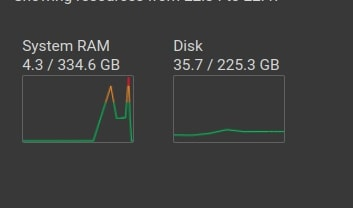


# Model 2.

MAX_LENGTH = 40  
VOCABULARY_SIZE = 15000  
BATCH_SIZE = 32  
BUFFER_SIZE = 1000  
EMBEDDING_DIM = 512  
UNITS = 512  
EPOCHS = 5  

## Model Definition

In [ ]:
from transformers import TFRobertaModel

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dense, Dropout, LayerNormalization, Flatten

In [ ]:
class ImageEncoder(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ImageEncoder, self).__init__(**kwargs)
        self.efficientnet = EfficientNetB0(include_top=False, weights='imagenet')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512)

    def call(self, inputs):
        x = self.efficientnet(inputs)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [ ]:
class TextEncoder(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TextEncoder, self).__init__(**kwargs)
        self.roberta = TFRobertaModel.from_pretrained('roberta-base')

    def call(self, inputs):
        outputs = self.roberta(inputs)[0]
        outputs = tf.reduce_mean(outputs, axis=1)
        return outputs

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, num_decoder_layers, num_heads, key_dim, ff_dim, dropout_rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.decoder_layers = [DecoderLayer(embedding_dim, num_heads, key_dim, ff_dim, dropout_rate) for _ in range(num_decoder_layers)]
        self.output_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, encoded_features, training=False):
        embedding_output = self.embedding(inputs)
        padding_mask = tf.cast(tf.math.equal(inputs, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

        decoder_output = encoded_features
        for decoder_layer in self.decoder_layers:
            decoder_output = decoder_layer(embedding_output, padding_mask, training)

        output = self.output_layer(decoder_output)
        return output

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, key_dim, ff_dim, dropout_rate, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(embedding_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, padding_mask, training):
        attention_output = self.attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            return_attention_scores=False,
        )

        attention_output = self.dropout(attention_output, training=training)
        attention_output = self.layernorm1(attention_output + inputs)

        ffn_output = self.ffn(attention_output)
        ffn_output = self.dropout(ffn_output, training=training)
        ffn_output = self.layernorm2(ffn_output + attention_output)

        return ffn_output


In [ ]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_decoder_layers, num_heads, key_dim, ff_dim, dropout_rate, **kwargs):
        super(ImageCaptioningModel, self).__init__(**kwargs)
        self.image_encoder = ImageEncoder()
        self.encoder = TextEncoder()
        self.decoder = Decoder(vocab_size, embedding_dim, num_decoder_layers, num_heads, key_dim, ff_dim, dropout_rate)
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.cast(tf.argmax(y_pred, axis=2),dtype = tf.int32))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(captions)
        # print('caption_dim',captions.shape)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        encoded_features = tf.keras.layers.concatenate([img_embed, encoder_output])
        # print('image_dim',img_embed.shape)
        # print('rob_output_dim',encoder_output.shape)
        # print('concat_dim',encoded_features.shape)
        # print('y_input_dim',y_input.shape)
        # print('y_true_dim',y_true.shape)
        y_pred = self.decoder(
            y_input, encoded_features, training=True
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    def train_step(self, x):
        imgs, captions = x
        img_embed = self.image_encoder(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.image_encoder(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
model = ImageCaptioningModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=512,
    num_decoder_layers=6,
    num_heads=8,
    key_dim=64,
    ff_dim=2048,
    dropout_rate=0.1
)

In [ ]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy,
    # run_eagerly=True
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size = 32,
    validation_data=test_dataset,
    callbacks=[early_stopping],
)

In [ ]:
pd.DataFrame(history.history).plot()

# Results

In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)

    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))

    img = tf.expand_dims(img, axis=0)
    img_embed = model.image_encoder(img)
    img_encoded = model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = tokenizer.decode(pred_idx,skip_special_tokens=True)
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [ ]:
from PIL import Image

In [ ]:
idx = random.randrange(0, len(data))
img_path = data.iloc[idx].image
pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
Image.open(img_path)

In [ ]:
idx = random.randrange(0, len(data))
img_path = data.iloc[idx].image
img_path = '/content/Screenshot 2024-05-02 111030.png'
pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
Image.open(img_path)

In [ ]:
model.save_weights('BaseModel.h5')